In [38]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

In [39]:
#!pip install mediapipe
#!python3

In [40]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

In [41]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose
 
# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)
 
# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils

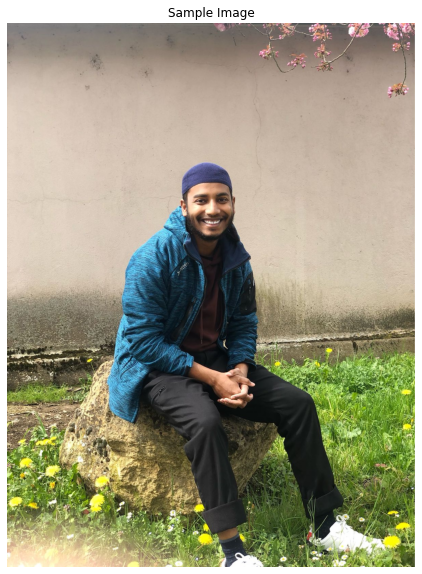

In [42]:
# Read an image from the specified path.
sample_img = cv2.imread('rakibul.jpeg')

# Specify a size of the figure.
plt.figure(figsize = [10, 10])

# Display the sample image, also convert BGR to RGB for display. 
plt.title("Sample Image");plt.axis('off');plt.imshow(sample_img[:,:,::-1]);plt.show()

In [43]:
results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
 
# Check if any landmarks are found.
if results.pose_landmarks:
    
    # Iterate two times as we only want to display first two landmarks.
    for i in range(2):
        
        # Display the found normalized landmarks.
        print(f'{mp_pose.PoseLandmark(i).name}:\n{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]}') 

NOSE:
x: 0.5122975707054138
y: 0.35147255659103394
z: -0.6716781854629517
visibility: 0.9999798536300659

LEFT_EYE_INNER:
x: 0.5242946743965149
y: 0.334432989358902
z: -0.6291965246200562
visibility: 0.9999635219573975



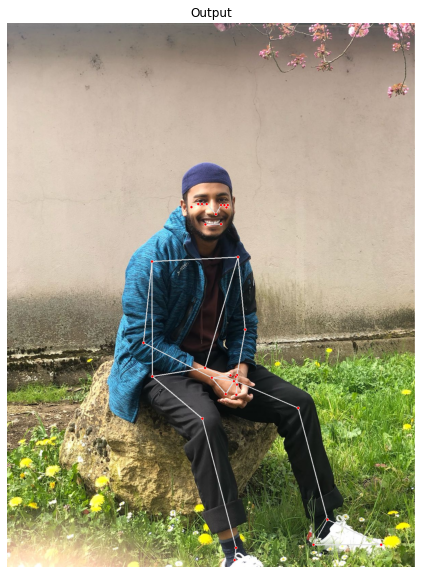

In [44]:
# Create a copy of the sample image to draw landmarks on.
img_copy = sample_img.copy()
 
# Check if any landmarks are found.
if results.pose_landmarks:
    
    # Draw Pose landmarks on the sample image.
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
       
    # Specify a size of the figure.
    fig = plt.figure(figsize = [10, 10])
 
    # Display the output image with the landmarks drawn, also convert BGR to RGB for display. 
    plt.title("Output");plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()


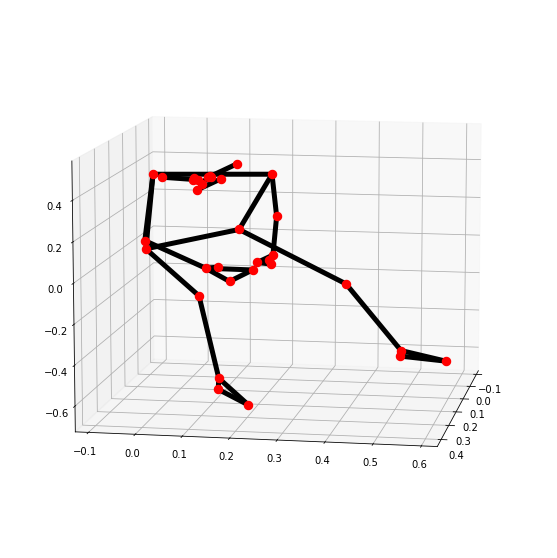

In [45]:
	
# Plot Pose landmarks in 3D.
mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

In [46]:
def detectPose(image, pose, display=True):
    '''
    This function performs pose detection on an image.
    Args:
        image: The input image with a prominent person whose pose landmarks needs to be detected.
        pose: The pose setup function required to perform the pose detection.
        display: A boolean value that is if set to true the function displays the original input image, the resultant image, 
                 and the pose landmarks in 3D plot and returns nothing.
    Returns:
        output_image: The input image with the detected pose landmarks drawn.
        landmarks: A list of detected landmarks converted into their original scale.
    '''
    
    # Create a copy of the input image.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the Pose Detection.
    results = pose.process(imageRGB)
    
    # Retrieve the height and width of the input image.
    height, width, _ = image.shape
    
    # Initialize a list to store the detected landmarks.
    landmarks = []
    
    # Check if any landmarks are detected.
    if results.pose_landmarks:
    
        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
        
        # Iterate over the detected landmarks.
        for landmark in results.pose_landmarks.landmark:
            
            # Append the landmark into the list.
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))
    
    # Check if the original input image and the resultant image are specified to be displayed.
    if display:
    
        # Display the original input image and the resultant image.
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
        # Also Plot the Pose landmarks in 3D.
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        
    # Otherwise
    else:
        
        # Return the output image and the found landmarks.
        return output_image, landmarks

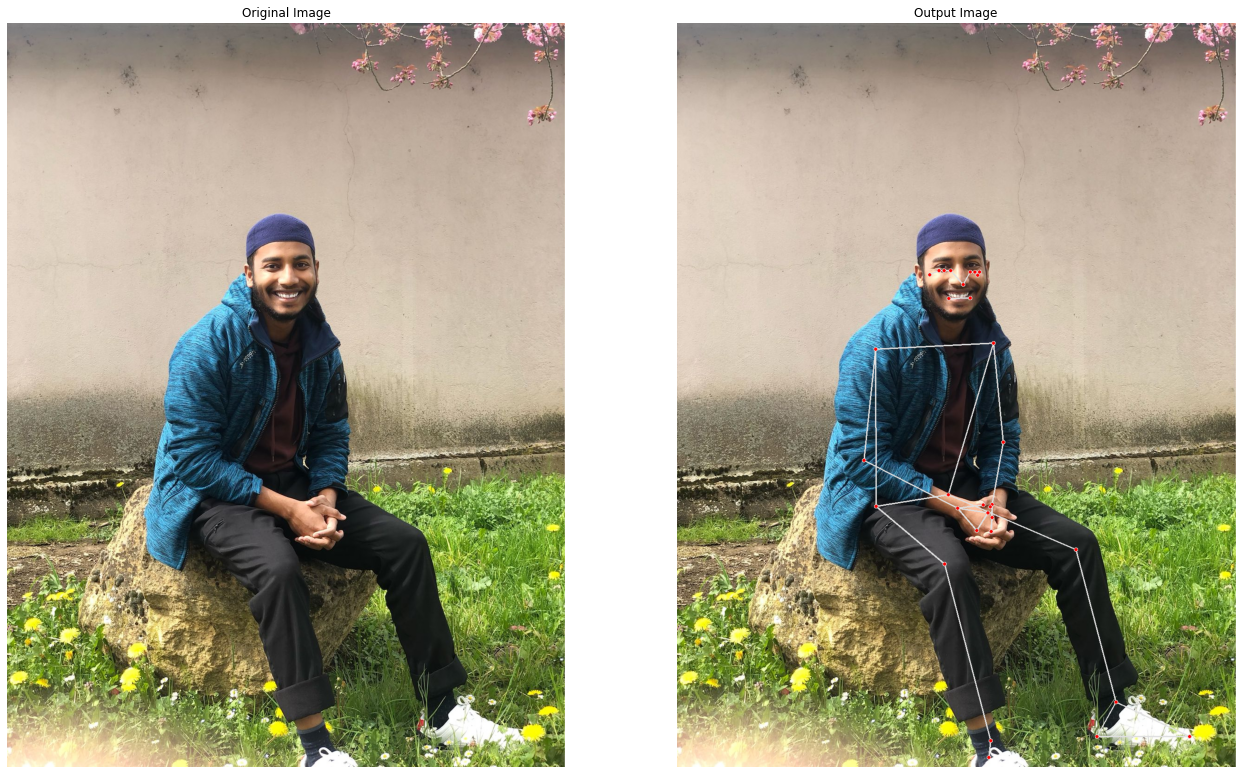

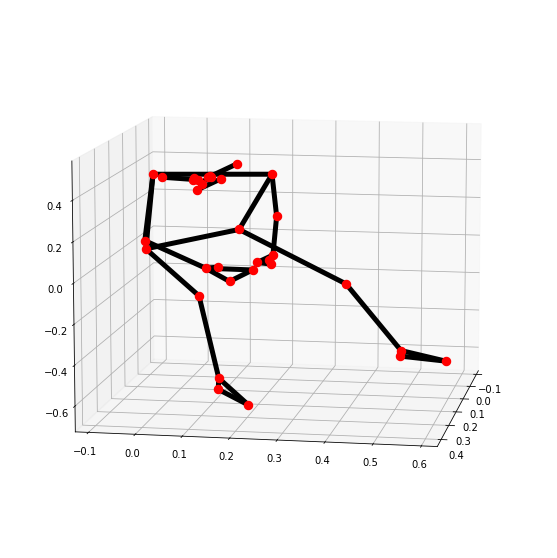

In [47]:
# Read another sample image and perform pose detection on it.
image = cv2.imread('rakibul.jpeg')
detectPose(image, pose, display=True)

In [48]:
def calculateAngle(landmark1, landmark2, landmark3):
    '''
    This function calculates angle between three different landmarks.
    Args:
        landmark1: The first landmark containing the x,y and z coordinates.
        landmark2: The second landmark containing the x,y and z coordinates.
        landmark3: The third landmark containing the x,y and z coordinates.
    Returns:
        angle: The calculated angle between the three landmarks.
 
    '''
 
    # Get the required landmarks coordinates.
    x1, y1, _ = landmark1
    x2, y2, _ = landmark2
    x3, y3, _ = landmark3
 
    # Calculate the angle between the three points
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))
    
    # Check if the angle is less than zero.
    if angle < 0:
 
        # Add 360 to the found angle.
        angle += 360
    
    # Return the calculated angle.
    return angle

In [49]:
# Calculate the angle between the three landmarks.
angle = calculateAngle((558, 326, 0), (642, 333, 0), (718, 321, 0))
 
# Display the calculated angle.
print(f'The calculated angle is {angle}')

The calculated angle is 166.26373169437744


In [50]:
def classifyPose(landmarks, output_image, display=False):
    '''
    This function classifies yoga poses depending upon the angles of various body joints.
    Args:
        landmarks: A list of detected landmarks of the person whose pose needs to be classified.
        output_image: A image of the person with the detected pose landmarks drawn.
        display: A boolean value that is if set to true the function displays the resultant image with the pose label 
        written on it and returns nothing.
    Returns:
        output_image: The image with the detected pose landmarks drawn and pose label written.
        label: The classified pose label of the person in the output_image.
 
    '''
    
    # Initialize the label of the pose. It is not known at this stage.
    label = 'Unknown Pose'
 
    # Specify the color (Red) with which the label will be written on the image.
    color = (0, 0, 255)
    
    # Calculate the required angles.
    #----------------------------------------------------------------------------------------------------------------
    
    # Get the angle between the left shoulder, elbow and wrist points. 
    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    
    # Get the angle between the right shoulder, elbow and wrist points. 
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])   
    
    # Get the angle between the left elbow, shoulder and hip points. 
    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])
 
    # Get the angle between the right hip, shoulder and elbow points. 
    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])
 
    # Get the angle between the left hip, knee and ankle points. 
    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])
 
    # Get the angle between the right hip, knee and ankle points 
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
    
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if it is the warrior II pose or the T pose.
    # As for both of them, both arms should be straight and shoulders should be at the specific angle.
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if the both arms are straight.
    if left_elbow_angle >= 165 and left_elbow_angle <= 195 and right_elbow_angle>=  165 and right_elbow_angle <= 195:
 
        # Check if shoulders are at the required angle.
        if left_shoulder_angle >=  80 and left_shoulder_angle <= 110 and right_shoulder_angle >= 80 and right_shoulder_angle <= 110:
 
    # Check if it is the warrior II pose.
    #----------------------------------------------------------------------------------------------------------------
 
            # Check if one leg is straight.
            if left_knee_angle >=  165 and left_knee_angle <= 195 or right_knee_angle >=  165 and right_knee_angle <=195:
 
                # Check if the other leg is bended at the required angle.
                if left_knee_angle >=  90 and left_knee_angle <= 120 or right_knee_angle >=  90 and right_knee_angle <= 120:
 
                    # Specify the label of the pose that is Warrior II pose.
                    label = 'Warrior II Pose' 
                        
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if it is the T pose.
    #----------------------------------------------------------------------------------------------------------------
    
            # Check if both legs are straight
            if left_knee_angle >=  160 and left_knee_angle <= 195 and right_knee_angle >=  160 and right_knee_angle <= 195:
 
                # Specify the label of the pose that is tree pose.
                label = 'T Pose'
 
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if it is the tree pose.
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if one leg is straight
    if left_knee_angle >=  165 and left_knee_angle <= 195 or right_knee_angle >=  165 and right_knee_angle <= 195:
 
        # Check if the other leg is bended at the required angle.
        if left_knee_angle >=  315 and left_knee_angle <=335 or right_knee_angle >=  25 and right_knee_angle <= 45:
 
            # Specify the label of the pose that is tree pose.
            label = 'Tree Pose'
                
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if the pose is classified successfully
    if label != 'Unknown Pose':
        
        # Update the color (to green) with which the label will be written on the image.
        color = (0, 255, 0)  
    
    # Write the label on the output image. 
    cv2.putText(output_image, label, (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, color, 2)
    
    # Check if the resultant image is specified to be displayed.
    if display:
    
        # Display the resultant image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
    else:
        
        # Return the output image and the classified label.
        return output_image, label

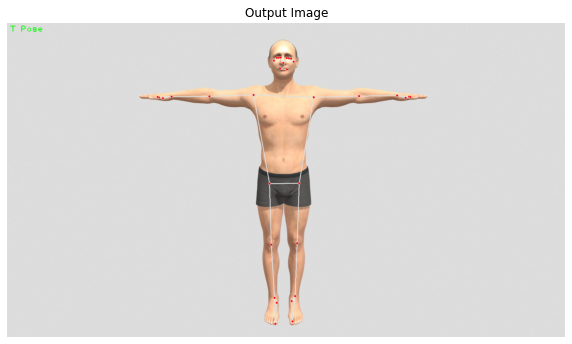

In [51]:

# Read another sample image and perform pose classification on it.
image = cv2.imread('T.jpeg')
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)